# Import Libraries

In [55]:
# Import all the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os
import re
import pickle

from google.colab import drive
drive.mount('/content/drive')

from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
# from mord import LogisticAT
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Activation, Dropout
from kerastuner.tuners import RandomSearch

from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import mean_absolute_error, mean_squared_error

import warnings
warnings.filterwarnings('ignore')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Specify the directory containing TSV files
tsv_dir = '/content/drive/MyDrive/dataset/train/boxes_transcripts_labels'
dir_list = os.listdir(tsv_dir)

# Total no of files
print(len(dir_list))

600


# Data PreProcessing

In [3]:
# Define a list of predefined column names
new_columns = [
    'employerName',
    'employerAddressStreet_name',
    'employerAddressCity',
    'employerAddressState',
    'employerAddressZip',
    'einEmployerIdentificationNumber',
    'employeeName',
    'ssnOfEmployee',
    'box1WagesTipsAndOtherCompensations',
    'box2FederalIncomeTaxWithheld',
    'box3SocialSecurityWages',
    'box4SocialSecurityTaxWithheld',
    'box16StateWagesTips',
    'box17StateIncomeTax',
    'taxYear']

I have designed a function to read and process multiple TSV files, filter and pivot the data, and then create a consolidated DataFrame with a specific column order of 15 Entities.

In [4]:
# Initialize an empty list to store dataframes
list1 = []

# Iterate through each TSV file in the directory
for file in dir_list:
        loc = os.path.join(tsv_dir, file)
        df = pd.read_csv(loc, header=None)

        # Read the CSV file into a DataFrame
        df = pd.read_csv(loc, header=None)
        df.columns = ['start_index', 'end_index', 'x_top_left', 'y_top_left', 'x_bottom_right', 'y_bottom_right', 'transcript', 'field']

        # Filter out rows with 'field' equal to 'OTHER'
        df = df[df['field'] != 'OTHER']

        # Select and group relevant columns
        df = df[['field', 'transcript']].groupby('field')['transcript'].apply(' '.join).reset_index()

        # Pivot the DataFrame and fill NaN values
        df = df.pivot_table(index=None, columns='field', values='transcript', aggfunc=' '.join, fill_value=None)

        # Reorder columns based on the desired order
        df = df.reindex(columns=new_columns)

        # Append the resulting row to the list
        list1.append(list(df.iloc[0]))

# Create the final DataFrame
train = pd.DataFrame(list1, columns=new_columns)

# Print the final DataFrame
train

,employerName,employerAddressStreet_name,employerAddressCity,employerAddressState,employerAddressZip,einEmployerIdentificationNumber,employeeName,ssnOfEmployee,box1WagesTipsAndOtherCompensations,box2FederalIncomeTaxWithheld,box3SocialSecurityWages,box4SocialSecurityTaxWithheld,box16StateWagesTips,box17StateIncomeTax,taxYear
0,Mcconnell-Whitaker and Sons,19841 Torres Bridge,South Joyfurt,TN,10442-2651,16-8543273,Marcia Campbell,178-86-9660,167506 94,12816. 96,184863.25,14142 . 04,83037.93,5840. 81,2019
1,Roberson-Little PLC,8162 Willie Road,Reynoldsside,WI,71434-3665,62-9391778,Miss Candace,NaN,119440 . 15,36367. 43,130527. 85,9985 . 38,63847 .38,3340 . 7,2018
2,Valenzuela Group LLC,0794 Stanton Valley,Timothymouth,MT,73355-5435,84-8708100,Daniel Ward,010-28-9679,128268 . 61,32246. 83,92380 .86,7067 . 14,69133 . 16,"3392, 89",2018
3,NaN,2676 William Mountain,Danielsfort,MN,31233-5510,25-0180103,Kimberly Villanueva,num-43-4102,41345. 53,10537 .,NaN,NaN,tips. 46 51,. 1483 14,2018
4,Mendoza-Ruiz Inc,39663 Vincent Green Apt. 286,New Christine,CO,71756-8975,45-4647132,Ricky Franklin,806-48-9778,211698. 37,69690 . 62,195254 .17,14936 . 94,112767 . 4,7884 .59,2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,Group Lee-williams,83244 Gary Ways Apt. 177,Tonyaberg,CA,42158-3720,NaN,David Paul,671-21-9179,NaN,. 37298 89,88 Cha8 55,NaN,NaN,4530 .22,2018
596,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018
597,"Alvarez, Milos and Grant PLC",603 Janie Rapids,Meat Brian,ND,93513-9121,$9-0141149,Beth Bart,246-91-2924,241879.54,NaN,NaN,19276.3,NaN,NaN,2018
598,"Kelley, Fuller and Bennett Ltd",0687 Jennifer Islands Apt. 022,Lake Ray,NH,67095-6576,36-6965882,Christine? /Acosta,0,97993 . 64,27072 . 16,118640.22,9091.28,NaN,4083.73,2018


I extract all the the data from TSV file.

But, there are some wrongly extracted. So, I will try to filter out all those.

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 15 columns):
 #   Column                              Non-Null Count  Dtype 
---  ------                              --------------  ----- 
 0   employerName                        560 non-null    object
 1   employerAddressStreet_name          568 non-null    object
 2   employerAddressCity                 562 non-null    object
 3   employerAddressState                552 non-null    object
 4   employerAddressZip                  560 non-null    object
 5   einEmployerIdentificationNumber     541 non-null    object
 6   employeeName                        565 non-null    object
 7   ssnOfEmployee                       466 non-null    object
 8   box1WagesTipsAndOtherCompensations  519 non-null    object
 9   box2FederalIncomeTaxWithheld        519 non-null    object
 10  box3SocialSecurityWages             511 non-null    object
 11  box4SocialSecurityTaxWithheld       504 non-null    object

Every feature is object datatype. I will try to convert all the numeric columns into float datatype

In [6]:
# Converting 'taxYear' column to float datatype
train['taxYear'] = pd.to_numeric(train['taxYear'], errors='coerce')

In [7]:
# Iterate through columns and count unique values
for column in train.columns:
    unique_count = train[column].nunique()
    print(f"Column '{column}' has {unique_count} unique values.")

Column 'employerName' has 476 unique values.
Column 'employerAddressStreet_name' has 487 unique values.
Column 'employerAddressCity' has 470 unique values.
Column 'employerAddressState' has 67 unique values.
Column 'employerAddressZip' has 467 unique values.
Column 'einEmployerIdentificationNumber' has 460 unique values.
Column 'employeeName' has 482 unique values.
Column 'ssnOfEmployee' has 354 unique values.
Column 'box1WagesTipsAndOtherCompensations' has 488 unique values.
Column 'box2FederalIncomeTaxWithheld' has 493 unique values.
Column 'box3SocialSecurityWages' has 481 unique values.
Column 'box4SocialSecurityTaxWithheld' has 481 unique values.
Column 'box16StateWagesTips' has 486 unique values.
Column 'box17StateIncomeTax' has 495 unique values.
Column 'taxYear' has 3 unique values.


Here, I checked that 'taxYear' column has min unique values. So, I can count the total values of each year.

In [8]:
train['taxYear'].value_counts()

2018.0    396
2019.0    147
2910.0      1
Name: taxYear, dtype: int64

Almost 70% data are of 2018 year.

Only one missclassified value, So I can simply remove it.

Also, remove the un-necessary columns form the dataset

In [9]:
# Remove rows where 'taxYear' is equal to 2910 (assuming it's a typo)
train = train[train['taxYear'] != 2910]

# Drop unnecessary columns from the DataFrame
columns_to_drop = ['employerName', 'employerAddressStreet_name', 'employerAddressZip',
                   'einEmployerIdentificationNumber', 'ssnOfEmployee', 'employeeName']
train = train.drop(columns=columns_to_drop)

Let's, find total % of missing values after extracting the data from TSV file.

In [10]:
# Total percentage of null values
total_cells = len(train)  # Total number of cells in the DataFrame
missing_cells = total_cells-len(train.dropna())  # Total number of missing (NaN) cells

# Calculate the percentage of missing values
percentage_missing = (missing_cells / total_cells) * 100

# Print the percentage of missing values
percentage_missing

37.061769616026716

In [11]:
# Assuming 'ds' is your DataFrame
nan_counts = train.isna().sum()

# Print the counts of NaN values for each column
print(nan_counts)

employerAddressCity                   37
employerAddressState                  47
box1WagesTipsAndOtherCompensations    80
box2FederalIncomeTaxWithheld          80
box3SocialSecurityWages               88
box4SocialSecurityTaxWithheld         95
box16StateWagesTips                   90
box17StateIncomeTax                   80
taxYear                               56
dtype: int64


I designed a function to clean and convert strings to float values, handling various edge cases and returning NaN when necessary. It's useful for preprocessing data when working with numeric columns in a dataset, especially when dealing with potentially messy or inconsistent input data.

In [12]:
# converting all the numeric columns to float datatype
def convert(st):
        # If null value is there then return null
        if 'NaN' in st or 'nan' in st:
            return float(np.nan)

        # Remove spaces and replace '-' with '.'
        st = st.replace(' ', '').replace('-', '.')

        # Use a regular expression to remove leading and trailing non-numeric characters
        st = re.sub(r'^[^0-9]*|[^0-9]*$', '', st)

        # Use a regular expression to check if the string contains only numeric characters and '.'
        if not re.match(r'^[0-9.]*$', st) or st == '':
            return np.nan

        # Check if '.' is not present take as null
        if '.' not in st:
            return float(np.nan)

        return float(st)

In [13]:
# Numeric columns to convert
numeric_columns = ['box1WagesTipsAndOtherCompensations', 'box2FederalIncomeTaxWithheld',
                   'box3SocialSecurityWages','box4SocialSecurityTaxWithheld',
                   'box16StateWagesTips', 'box17StateIncomeTax']

In [14]:
# Call the function to convert
for col in numeric_columns:
        train[col] = train[col].apply(lambda st: convert(str(st)))

# Print the final DataFrame
train.head()

,employerAddressCity,employerAddressState,box1WagesTipsAndOtherCompensations,box2FederalIncomeTaxWithheld,box3SocialSecurityWages,box4SocialSecurityTaxWithheld,box16StateWagesTips,box17StateIncomeTax,taxYear
0,South Joyfurt,TN,NaN,12816.96,184863.25,14142.04,83037.93,5840.81,2019.0
1,Reynoldsside,WI,119440.15,36367.43,130527.85,9985.38,63847.38,3340.70,2018.0
2,Timothymouth,MT,128268.61,32246.83,92380.86,7067.14,69133.16,NaN,2018.0
3,Danielsfort,MN,41345.53,NaN,NaN,NaN,NaN,NaN,2018.0
4,New Christine,CO,211698.37,69690.62,195254.17,14936.94,112767.40,7884.59,2019.0


In [15]:
# Assuming 'ds' is your DataFrame
nan_counts = train.isna().sum()

# Print the counts of NaN values for each column
print(nan_counts)

employerAddressCity                    37
employerAddressState                   47
box1WagesTipsAndOtherCompensations    124
box2FederalIncomeTaxWithheld          136
box3SocialSecurityWages               130
box4SocialSecurityTaxWithheld         130
box16StateWagesTips                   191
box17StateIncomeTax                   149
taxYear                                56
dtype: int64


In [16]:
# Print a descriptive statistics summary of a given dataframe
train.describe()

,box1WagesTipsAndOtherCompensations,box2FederalIncomeTaxWithheld,box3SocialSecurityWages,box4SocialSecurityTaxWithheld,box16StateWagesTips,box17StateIncomeTax,taxYear
count,475.000000,463.000000,469.000000,469.000000,408.000000,450.000000,543.000000
mean,145072.162821,32163.476592,144944.751087,11091.494925,72361.603358,5387.630201,2018.270718
std,60429.678826,18938.149592,68395.484123,6624.601081,30797.491191,3184.061899,0.444741
min,5718.940000,9.352120,17063.080000,276.420000,10956.000000,8.568100,2018.000000
25%,93506.675000,17521.975000,89656.290000,6624.000000,44865.332500,3011.177500,2018.000000
50%,145660.200000,27993.410000,137908.530000,10545.750000,72301.510000,4671.935000,2018.000000
75%,195581.690000,44213.480000,196502.250000,14936.940000,97781.982500,7198.167500,2019.000000
max,249641.710000,97761.360000,414913.130000,96928.060000,134026.290000,19421.530000,2019.000000


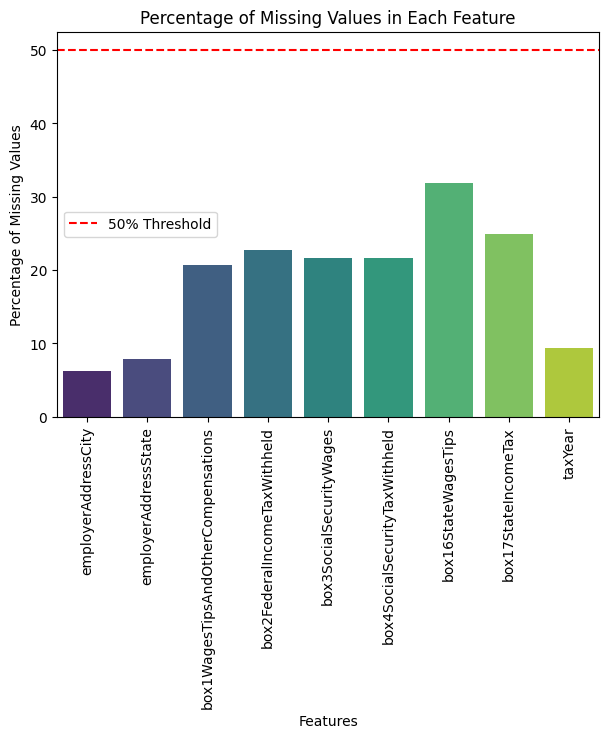

In [17]:
# Calculate the percentage of missing values in each column
missing_percentage = (train.isnull().mean() * 100).round(2)

# Set the figure size
plt.figure(figsize=(7, 5))  # Adjust the width and height as needed

# Create a bar plot to visualize missing percentages
ax = sns.barplot(x=missing_percentage.index, y=missing_percentage.values, palette="viridis")

# Set a threshold for highlighting features with more than 50% missing values
threshold = 50
ax.axhline(y=threshold, color='r', linestyle='--', label=f'{threshold}% Threshold')

# Add labels and titles
plt.xlabel('Features')
plt.ylabel('Percentage of Missing Values')
plt.title('Percentage of Missing Values in Each Feature')
plt.xticks(rotation=90)  # Rotate x-axis labels for readability
plt.legend()

# Show the plot
plt.show()

I have around 40% of missing values. So, I will try imputation.

As, mputation is the process of replacing or filling in missing or incomplete data in a dataset with estimated or substituted values. It is a common technique in data preprocessing and analysis for several reasons like to avoid bias, maintain relationship, etc..


**KNN for imputation:**

K-Nearest Neighbors (KNN) imputation is a popular method for filling in missing values in a dataset. It's a non-parametric imputation technique that uses the values of nearby data points (neighbors) to estimate missing values.

In [18]:
# Select only the numeric columns from your training dataset
train_numeric = train[numeric_columns]

# Initialize the model with the (n_neighbors) set to 5 and Fit the KNN imputer
imputer = KNNImputer(n_neighbors=5)
df_imputed = imputer.fit_transform(train_numeric)

# Create a new DataFrame (df_imputed) with the imputed values and the same column names
df_imputed = pd.DataFrame(df_imputed, columns=numeric_columns)

# Print the final DataFrame
df_imputed.head()

,box1WagesTipsAndOtherCompensations,box2FederalIncomeTaxWithheld,box3SocialSecurityWages,box4SocialSecurityTaxWithheld,box16StateWagesTips,box17StateIncomeTax
0,160113.496,12816.960,184863.25,14142.040,83037.930,5840.810
1,119440.150,36367.430,130527.85,9985.380,63847.380,3340.700
2,128268.610,32246.830,92380.86,7067.140,69133.160,4713.476
3,41345.530,10725.298,48433.78,3399.198,21198.952,1587.886
4,211698.370,69690.620,195254.17,14936.940,112767.400,7884.590


# Outliers Treatment

Now, Try to observe the outliers through Box-Plot of each feature.

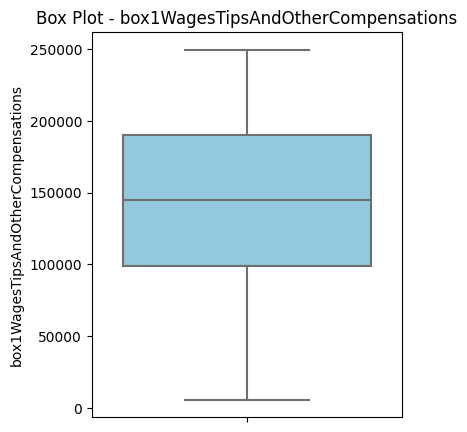

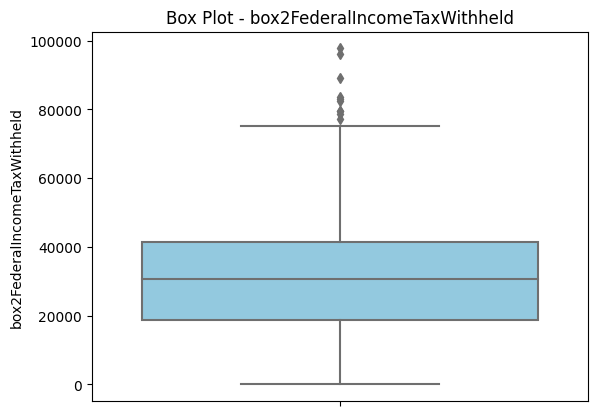

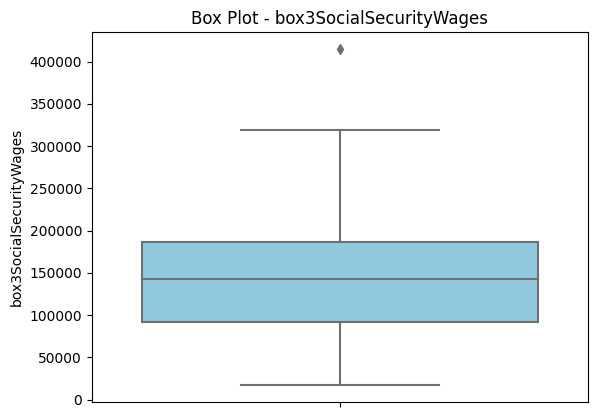

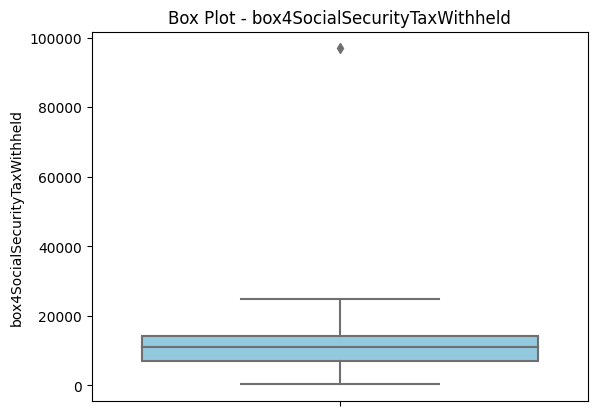

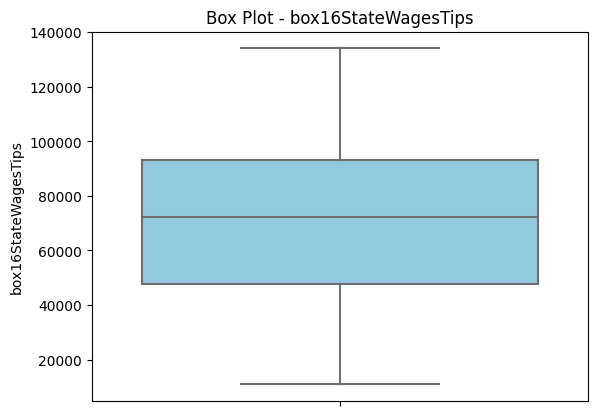

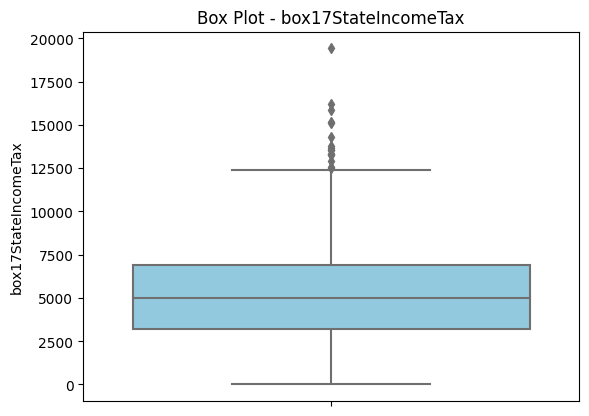

In [19]:
# Adjust the figure size if needed
plt.figure(figsize=(4, 5))  # Adjust the width and height as needed

# Loop through each column
for col in numeric_columns:
    sns.boxplot(y=df_imputed[col], color='skyblue', orient='v')
    plt.title(f'Box Plot - {col}')
    plt.xlabel('')  # Remove x-axis label if not needed
    plt.ylabel(col)  # Set y-axis label to the column name
    plt.show()

As, We cna see the outliers lies in 'box2FederalIncomeTaxWithheld' 'box3SocialSecurityWages', 'box4SocialSecurityTaxWithheld', and 'box17StateIncomeTax' columns.

**IQR**

To remove these outliers, I will apply IQR method.

The Interquartile Range (IQR) is a statistical measure that is commonly used for identifying and removing outliers from a dataset. It defines the range within which the middle 50% of the data falls. Outliers are typically defined as data points that fall below the first quartile (Q1) minus 1.5 times the IQR or above the third quartile (Q3) plus 1.5 times the IQR.


In [20]:
# Function to remove outliers using IQR method
def remove_outliers(df, col):
    # Calculate the first quartile (Q1), median (Q2), and third quartile (Q3) of the column
    Q1 = np.percentile(df[col], 25, interpolation='midpoint')
    Q2 = np.percentile(df[col], 50, interpolation='midpoint')
    Q3 = np.percentile(df[col], 75, interpolation='midpoint')

    # Calculate the Interquartile Range (IQR)
    IQR = Q3 - Q1

    # Calculate lower and upper limits for outliers
    lower_limit = Q1 - 1.5 * IQR
    upper_limit = Q3 + 1.5 * IQR

    # Identify and remove outliers from the DataFrame
    outliers = df[(df[col] < lower_limit) | (df[col] > upper_limit)]
    df_cleaned = df[~((df[col] < lower_limit) | (df[col] > upper_limit))]

    # Print information about the removal
    print(f'Column: {col}')
    print(f'Number of Outliers Removed: {len(outliers)}')

    return df_cleaned

In [21]:
df_imputed_no_outliers = df_imputed.copy()

# Loop through each numeric column and remove outliers
for col in numeric_columns:
    df_imputed_no_outliers = remove_outliers(df_imputed_no_outliers, col)

Column: box1WagesTipsAndOtherCompensations
Number of Outliers Removed: 0
Column: box2FederalIncomeTaxWithheld
Number of Outliers Removed: 10
Column: box3SocialSecurityWages
Number of Outliers Removed: 1
Column: box4SocialSecurityTaxWithheld
Number of Outliers Removed: 2
Column: box16StateWagesTips
Number of Outliers Removed: 0
Column: box17StateIncomeTax
Number of Outliers Removed: 17


# EDA

Let's visualizing the impact of before and after outlier removal on the distribution of numeric features in your dataset.

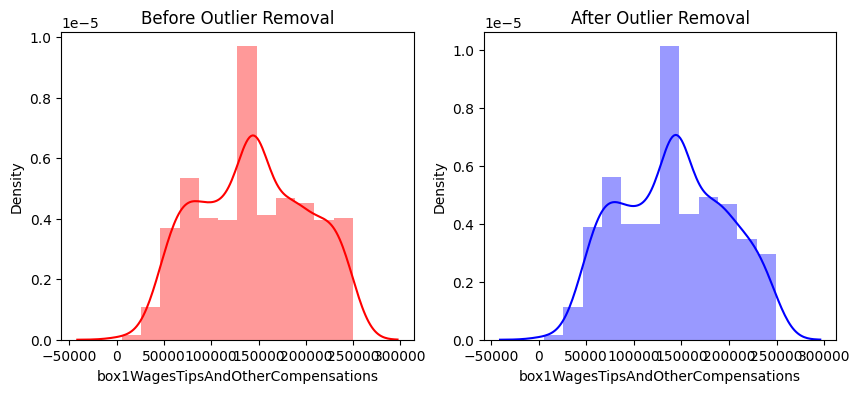

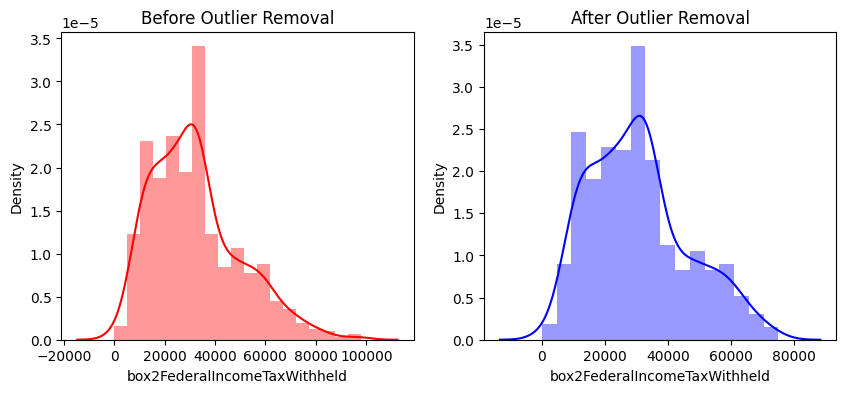

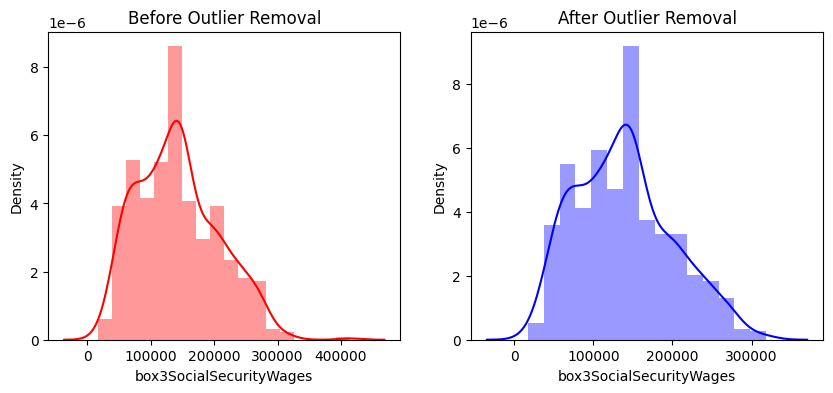

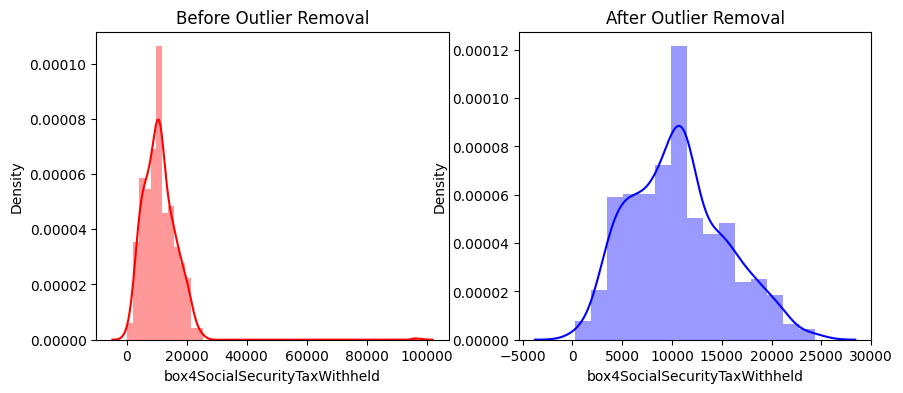

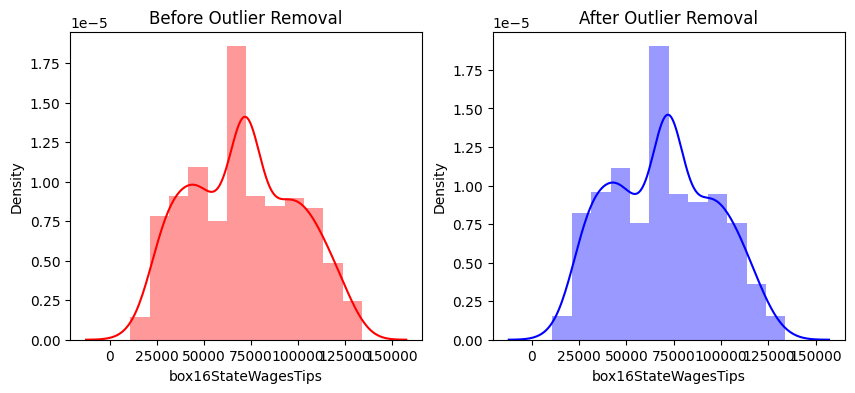

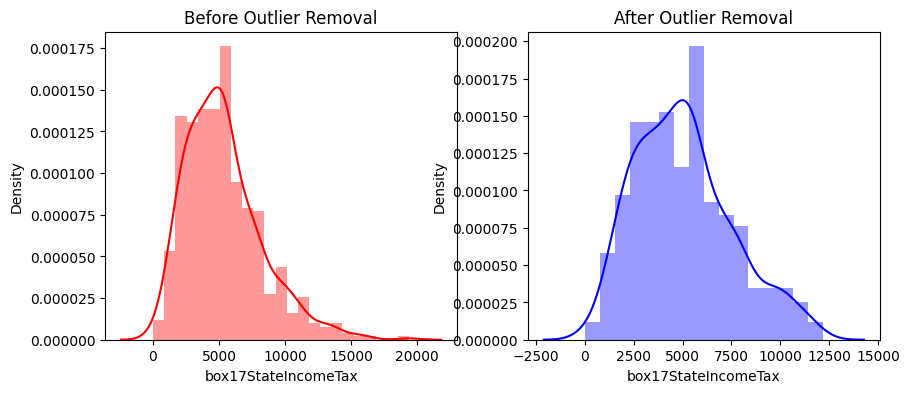

In [22]:
# Define a function to create histograms for a given feature before and after outlier removal
def compare_histograms(feature):
    # Create a subplot with two columns
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    # Plot the histogram before outlier removal
    axes[0].set_title("Before Outlier Removal")
    sns.distplot(df_imputed[feature], color='r', ax=axes[0])

    # Plot the histogram after outlier removal
    axes[1].set_title("After Outlier Removal")
    sns.distplot(df_imputed_no_outliers[feature], color='b', ax=axes[1])

    plt.show()

# Iterate through numeric columns and compare histograms
for feature in numeric_columns:
    compare_histograms(feature)

The before and after outlier removal has a significant effect on the data distribution.

As, we cna see in 'box4SocialSecurityTaxWithheld', and 'box17StateIncomeTax' columns.

In [23]:
# Copy the removed outliers dataframe to the original dataframe
df_imputed = df_imputed_no_outliers.copy()

**Correlation Matrix**

Heatmap is a graphical representation of data where values in a matrix are represented as colors. Heatmaps are particularly useful for visualizing relationships, patterns, and variations in data. Correlation coefficients measure the degree of linear association between two variables. The range of correlation coefficients is typically from -1 to 1, where:

1. A correlation coefficient of 1 indicates a perfect positive linear relationship, meaning that as one variable increases, the other also increases linearly.

2. A correlation coefficient of -1 indicates a perfect negative linear relationship, meaning that as one variable increases, the other decreases linearly.

3. A correlation coefficient of 0 indicates no linear relationship between the variables.

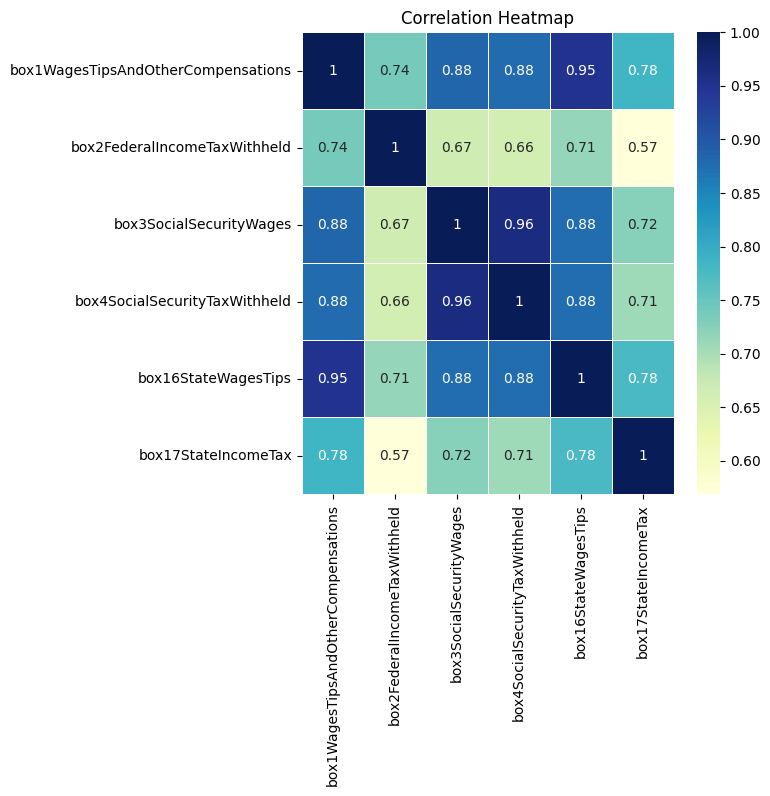

In [24]:
# Create a correlation matrix
correlation_matrix = df_imputed.corr()

# Create a heatmap of the correlation matrix
plt.figure(figsize=(6, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='YlGnBu', linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

1. Strong Positive Correlations: The diagonal elements of the matrix are all 1, which is expected.
There are strong positive correlations (close to 1) between several pairs of variables, such as "box1WagesTipsAndOtherCompensations" and "box3SocialSecurityWages," "box1WagesTipsAndOtherCompensations" and "box16StateWagesTips," and "box3SocialSecurityWages" and "box16StateWagesTips." This suggests that these variables tend to increase together linearly.

2. Strong Negative Correlations:
There are no strong negative correlations (close to -1) between any pairs of variables in the matrix.

3. Moderate Positive Correlations: Several pairs of variables have moderate positive correlations (between 0.7 and 0.9), indicating a moderate linear association. For example, "box1WagesTipsAndOtherCompensations" and "box2FederalIncomeTaxWithheld" have a correlation of approximately 0.738.

4. Moderate Positive to Weak Positive Correlations: Other pairs of variables have correlations ranging from moderate to weak positive correlations, such as "box1WagesTipsAndOtherCompensations" and "box17StateIncomeTax," which have a correlation of approximately 0.784.

In [25]:
# Extract the first two columns from the original train DataFrame
df1 = train.iloc[:, :2]

# Extract the last column from the original train DataFrame
df2 = train.iloc[:, -1]

# Concatenate the first two columns of train, the last column of train, and df_imputed
new_train = pd.concat([df1, df_imputed, df2], axis=1)

I combined Numeric columns with categorical columns to visualize the data with state wise to get more information.

Categorical columns contains null values as we didn't pre-procssed them. So, simply remove those.

In [26]:
# Drop all the null rows
new_train = new_train.dropna()

# Print the final DataFrame
new_train.head()

,employerAddressCity,employerAddressState,box1WagesTipsAndOtherCompensations,box2FederalIncomeTaxWithheld,box3SocialSecurityWages,box4SocialSecurityTaxWithheld,box16StateWagesTips,box17StateIncomeTax,taxYear
0,South Joyfurt,TN,160113.496,12816.960,184863.25,14142.040,83037.930,5840.810,2019.0
1,Reynoldsside,WI,119440.150,36367.430,130527.85,9985.380,63847.380,3340.700,2018.0
2,Timothymouth,MT,128268.610,32246.830,92380.86,7067.140,69133.160,4713.476,2018.0
3,Danielsfort,MN,41345.530,10725.298,48433.78,3399.198,21198.952,1587.886,2018.0
4,New Christine,CO,211698.370,69690.620,195254.17,14936.940,112767.400,7884.590,2019.0


Let's visualize the visualize the count of occurrences for each unique value in the 'employerAddressState' column of the 'new_train' DataFrame.

The resulting plot is a bar chart where each bar represents a unique state, and the height of each bar represents the count of occurrences of that state in the 'employerAddressState' column.

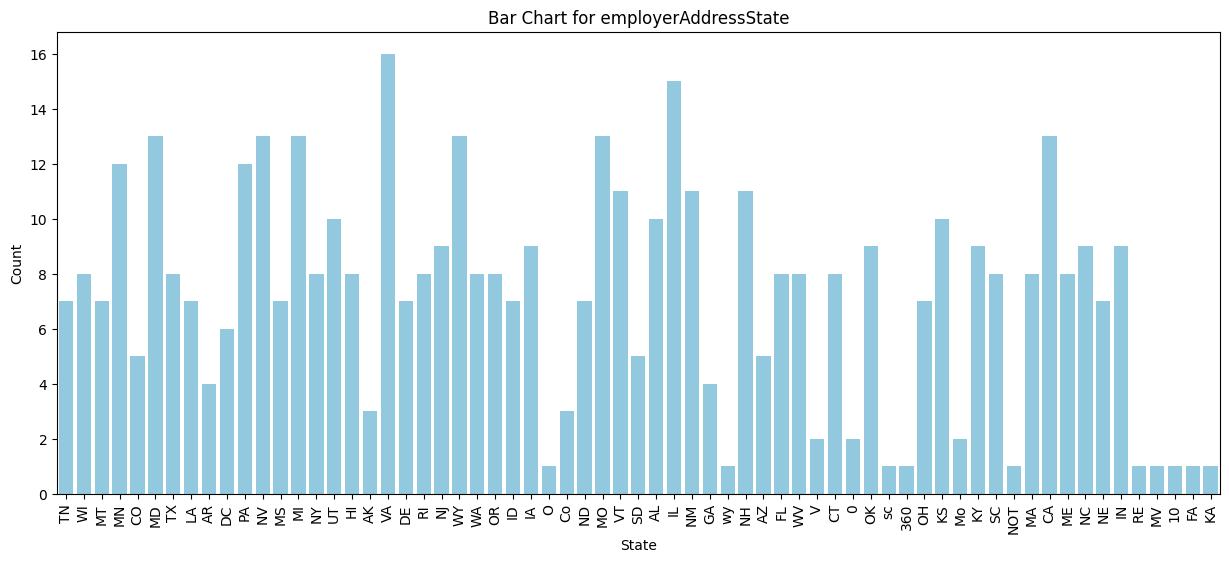

In [27]:
# Example: Bar chart for 'employerAddressState'
plt.figure(figsize=(15, 6))
sns.countplot(data=new_train, x='employerAddressState', color='skyblue')
plt.xlabel('State')
plt.ylabel('Count')
plt.title('Bar Chart for employerAddressState')
plt.xticks(rotation=90)
plt.show()

As, we see above, there are 3 states with highest no's. Those are 'VA', 'IV', and 'CV' states.

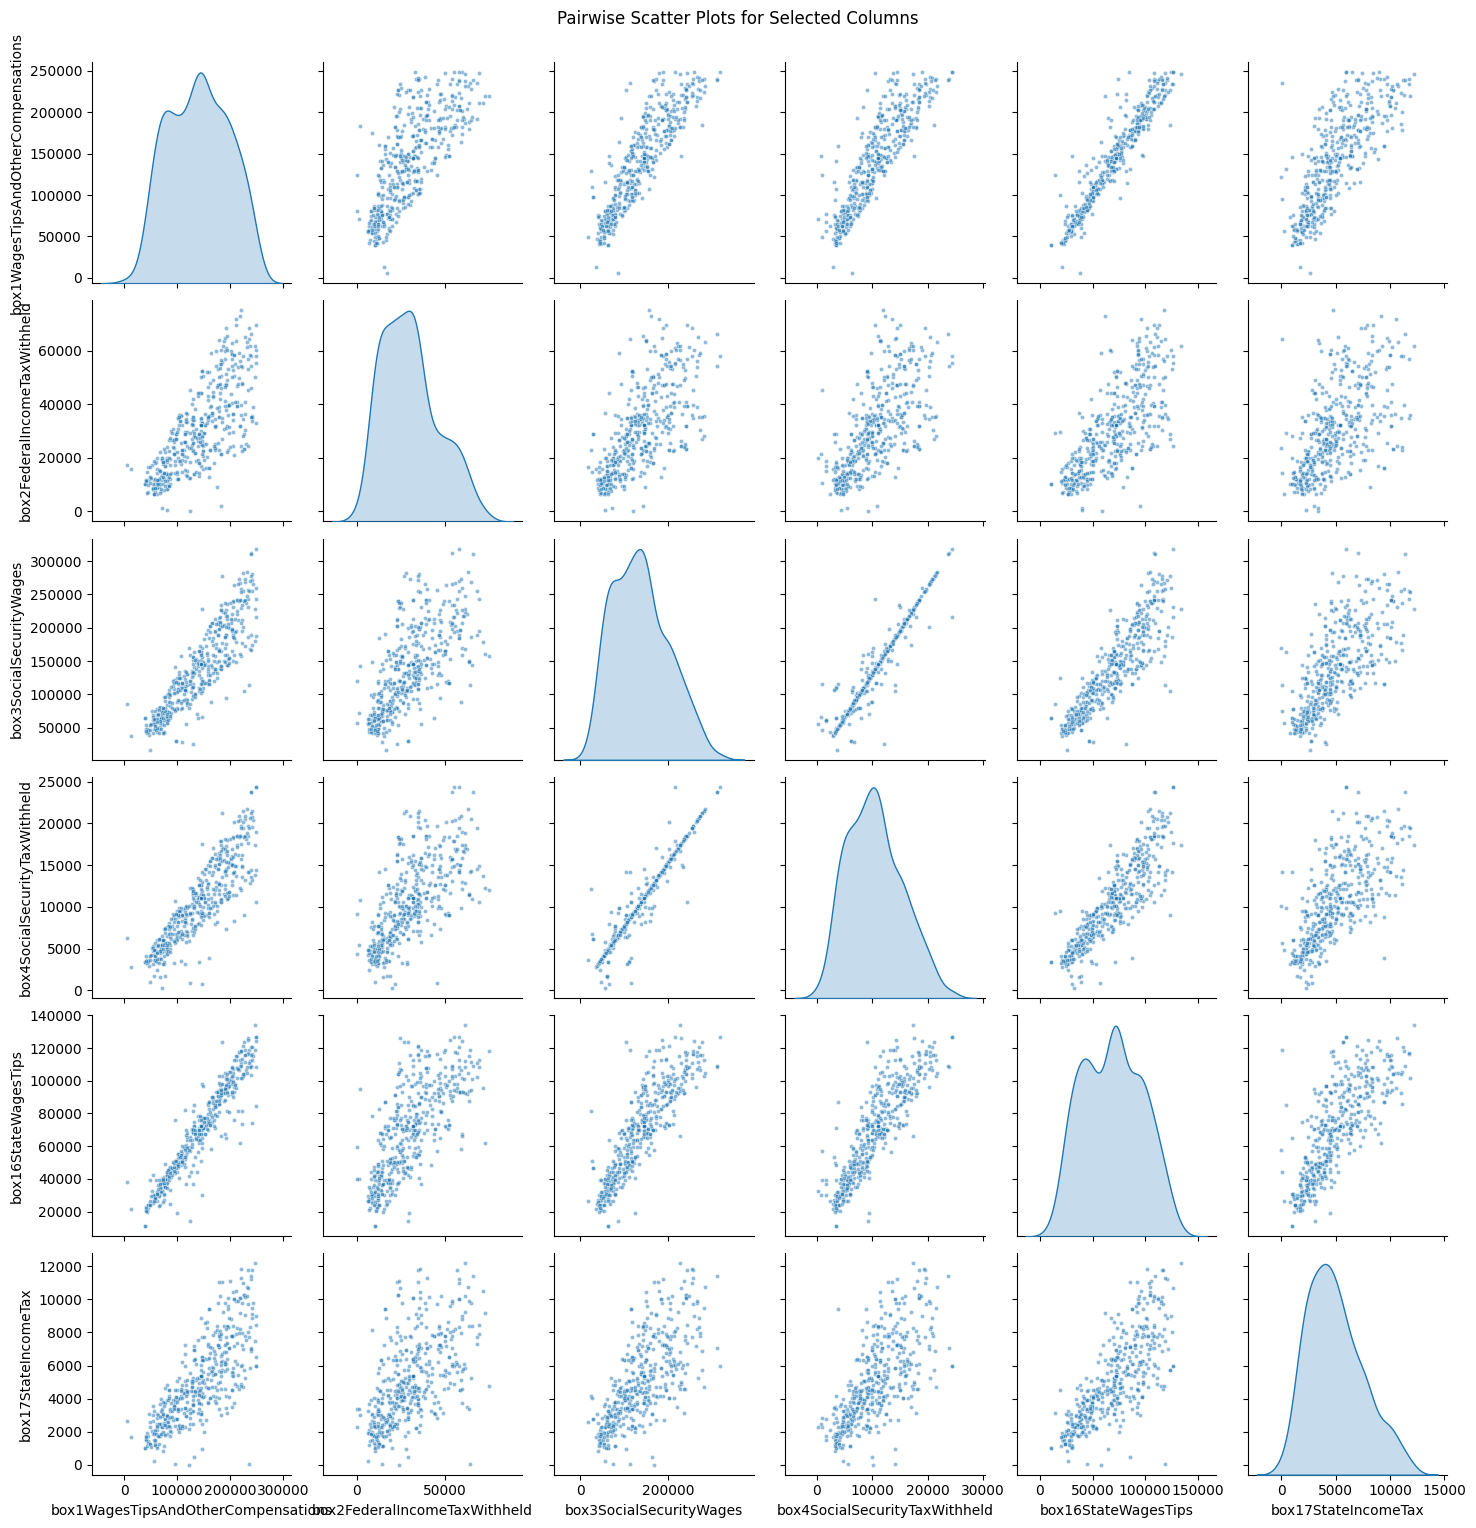

In [28]:
# Select the columns you want to include in the scatter matrix
selected_columns = ['employerAddressCity', 'employerAddressState', 'box1WagesTipsAndOtherCompensations', 'box2FederalIncomeTaxWithheld',
                    'box3SocialSecurityWages', 'box4SocialSecurityTaxWithheld', 'box16StateWagesTips', 'box17StateIncomeTax']

# Create a pairplot for the selected columns
sns.pairplot(new_train[selected_columns], diag_kind='kde', markers='.', plot_kws={'alpha':0.5})
plt.suptitle('Pairwise Scatter Plots for Selected Columns', y=1.02)
plt.show()

The resulting scatter matrix provides a visual representation of the pairwise relationships between the selected columns. Scatter plots show how two numerical variables are related to each other, and the diagonal KDE plots provide information about the distribution of each individual variable. This can be useful for identifying patterns, correlations, and outliers in the data.

In [29]:
# Group the DataFrame by 'taxYear' and calculate the maximum for each column within each group
max_per_taxYear = new_train.groupby('taxYear')[numeric_columns].max().reset_index()

# Print or work with the 'max_per_taxYear' DataFrame, which contains the maximum values per 'taxYear'
max_per_taxYear

,taxYear,box1WagesTipsAndOtherCompensations,box2FederalIncomeTaxWithheld,box3SocialSecurityWages,box4SocialSecurityTaxWithheld,box16StateWagesTips,box17StateIncomeTax
0,2018.0,248557.47,75109.88,318641.43,24376.07,126574.85,11792.03
1,2019.0,248637.54,69690.62,311331.53,23816.86,134026.29,12170.37


Here, I have maximum of each numeric columns grooup by tax year (max feature in  each year).



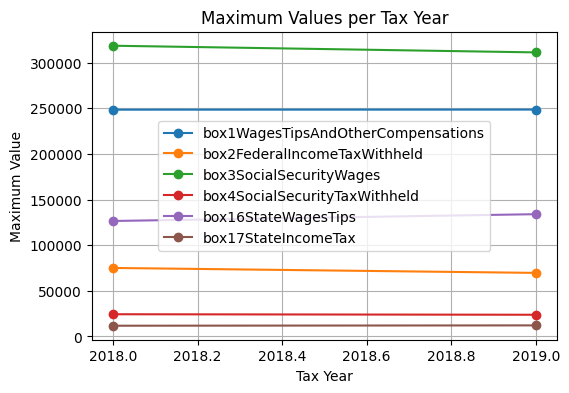

In [30]:
import matplotlib.pyplot as plt

# Group the DataFrame by 'taxYear' and calculate the maximum for each column within each group
max_per_taxYear = new_train.groupby('taxYear')[numeric_columns].max().reset_index()

# Set the figure size
plt.figure(figsize=(6, 4))

# Plot each numeric column
for column in numeric_columns:
    plt.plot(max_per_taxYear['taxYear'], max_per_taxYear[column], marker='o', label=column)

# Add labels and legend
plt.xlabel('Tax Year')
plt.ylabel('Maximum Value')
plt.title('Maximum Values per Tax Year')
plt.legend()

# Show the graph
plt.grid()
plt.show()

In [31]:
# Group the DataFrame by 'taxYear' and calculate the maximum for each column within each group
max_per_taxYear = new_train.groupby('employerAddressState')[numeric_columns].max().reset_index()

# Print or work with the 'max_per_taxYear' DataFrame, which contains the maximum values per 'taxYear'
max_per_taxYear.tail()

,employerAddressState,box1WagesTipsAndOtherCompensations,box2FederalIncomeTaxWithheld,box3SocialSecurityWages,box4SocialSecurityTaxWithheld,box16StateWagesTips,box17StateIncomeTax
60,WI,180517.28,54879.51,216275.424,17913.850,90966.530,8060.090
61,WV,235225.65,68550.27,254895.900,19499.540,110965.780,11831.660
62,WY,196625.39,35884.32,200379.520,15329.030,99246.640,10098.150
63,sc,206961.49,50523.36,263930.510,20191.300,96218.590,7190.990
64,wy,130327.06,29913.21,145172.246,11420.978,70172.804,5241.694


Here, I have maximum of each numeric columns grooup by state (max feature in each state).

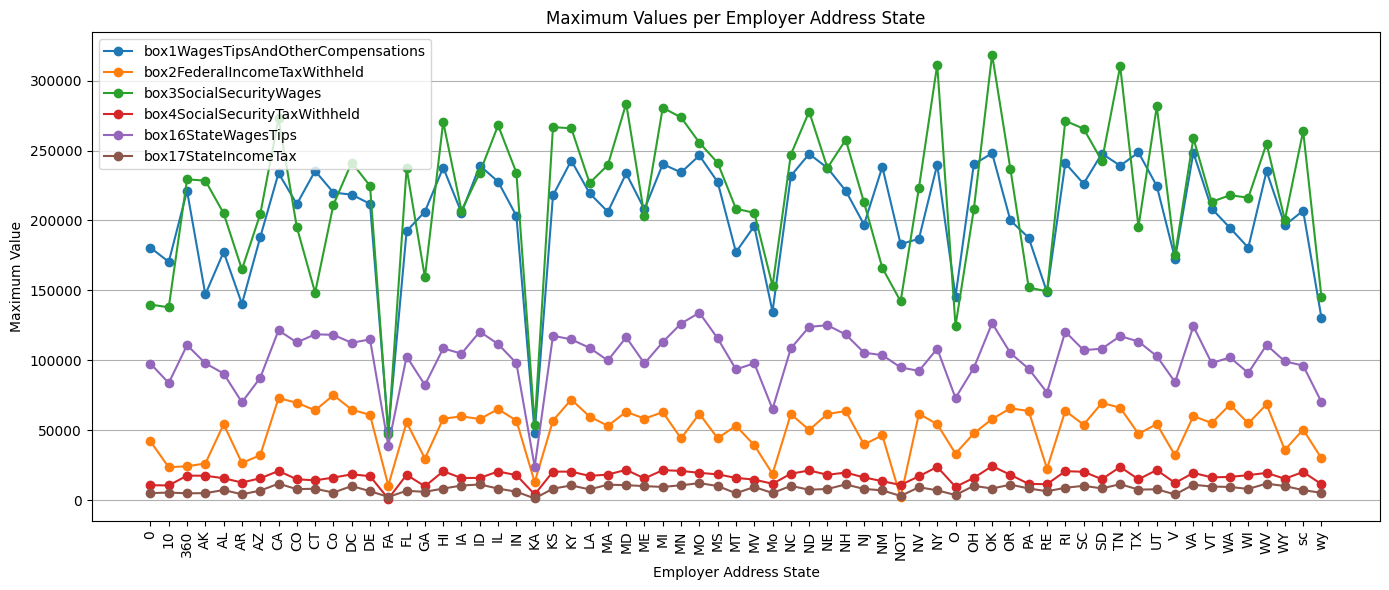

In [32]:
# Group the DataFrame by 'employerAddressState' and calculate the maximum for each column within each group
max_per_state = new_train.groupby('employerAddressState')[numeric_columns].max().reset_index()

# Set the figure size
plt.figure(figsize=(14, 6))

# Plot each numeric column
for column in numeric_columns:
    plt.plot(max_per_state['employerAddressState'], max_per_state[column],marker='o', label=column)

# Add labels and legend
plt.xlabel('Employer Address State')
plt.ylabel('Maximum Value')
plt.title('Maximum Values per Employer Address State')
plt.legend()

# Show the graph and Rotate x-axis labels for readability
plt.xticks(rotation=90)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

Lets, compare the values of each numeric column across the top 30 states (total 60+ states) with the highest frequency in the 'employerAddressState' column.

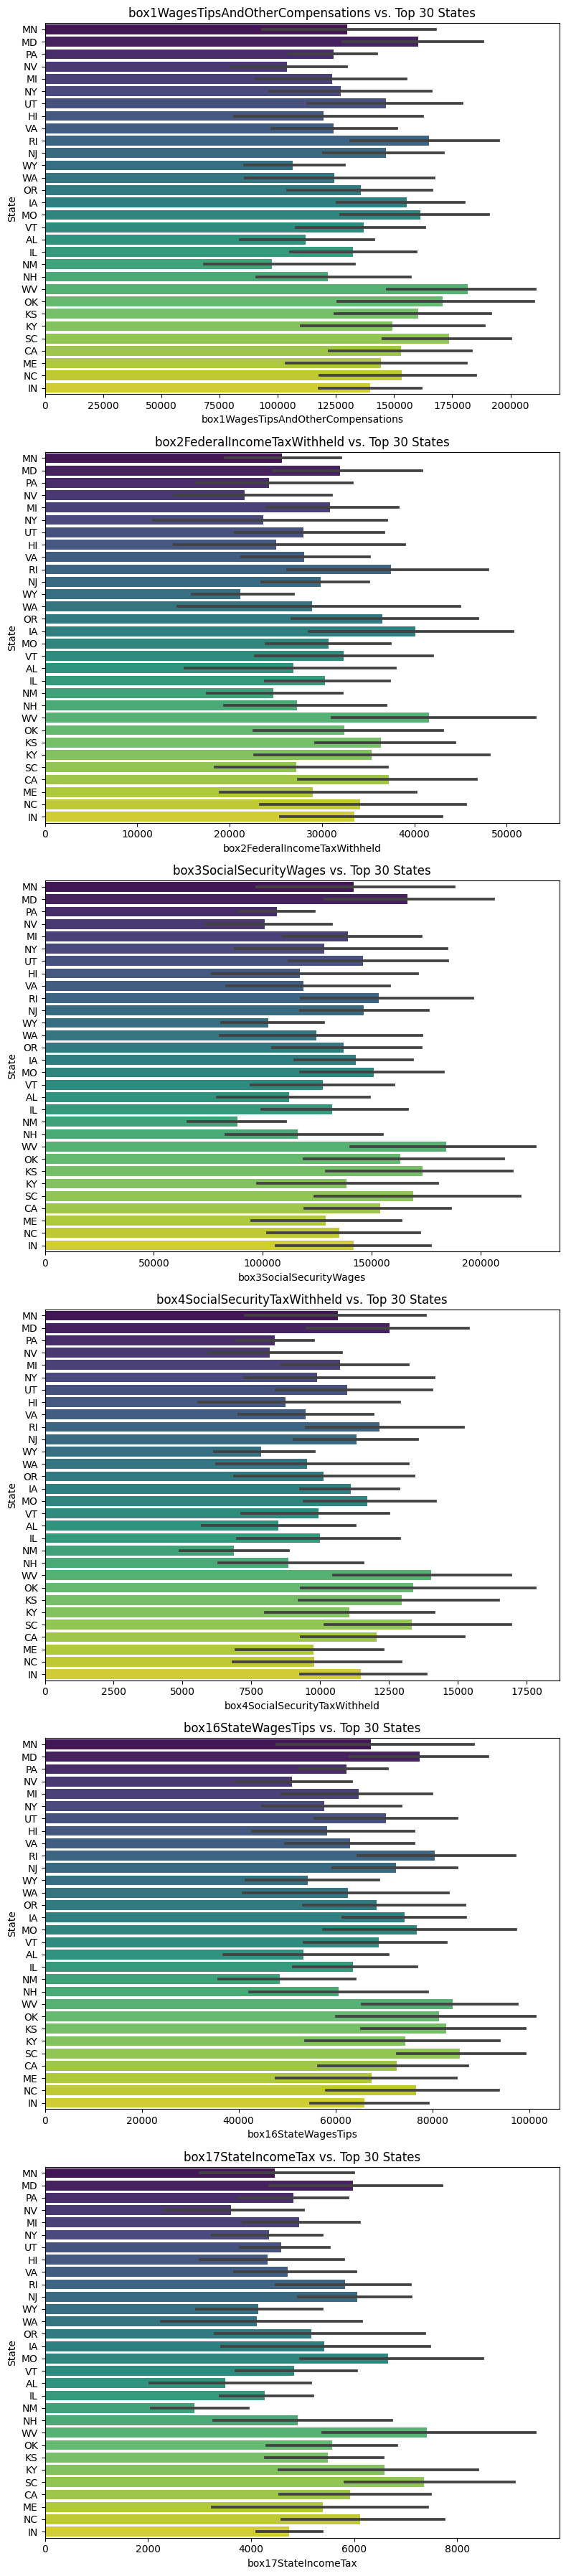

In [33]:
# Get the top 30 states based on their frequency in the 'employerAddressState' column
top_30_states = new_train['employerAddressState'].value_counts().head(30).index.tolist()

# Create subplots for each numeric column
fig, axes = plt.subplots(len(numeric_columns), 1, figsize=(8, 6 * len(numeric_columns)))

# Iterate through numeric columns and create horizontal bar charts for the top 30 states
for i, numeric_column in enumerate(numeric_columns):
    # Filter the data to include only the top 30 states
    filtered_data = new_train[new_train['employerAddressState'].isin(top_30_states)]

    # Create a horizontal bar chart for the current numeric column and top 30 states
    sns.barplot(data=filtered_data, x=numeric_column, y='employerAddressState', ax=axes[i], palette='viridis')
    axes[i].set_title(f'{numeric_column} vs. Top 30 States')
    axes[i].set_xlabel(numeric_column)
    axes[i].set_ylabel('State')

# Adjust spacing between subplots
plt.tight_layout()
plt.show()

During the pre-process, I visualize that there are mmany repeated field's in TSV file. We can also see the states and city with different highest value of each numeric columns. I also analyzed the missing transcript in few images.

As, I have total 16 classes including 'OTHER' field. So, I can use various ML algorithms such as Logistic Regression, Support Vector classifier, K-Nearest Neighbour, Decision Tree, Random Forest, AdaBoost, GradientBoosting, XGBoost and Extra Tree Regressor.

# Machine Learning Model Evaluations And Predictions

Let's create a dataframe of all TSVfiles of training dataset.

In [34]:
# Create an empty DataFrame to store the combined data
train_dataframe = pd.DataFrame()

# Iterate through the list of file names
for file in dir_list:
    loc = os.path.join(tsv_dir, file)
    df = pd.read_csv(loc, header=None, names=['start_index','end_index','x_top_left','y_top_left',
                                              'x_bottom_right','y_bottom_right', 'transcript','field'])

    # Concatenate the current DataFrame to org_dataframe
    train_dataframe = pd.concat([train_dataframe, df], ignore_index=True)

# Print the final DataFrame
train_dataframe.head()

,start_index,end_index,x_top_left,y_top_left,x_bottom_right,y_bottom_right,transcript,field
0,0,0,1015,102,1090,132,"Accurate,",OTHER
1,0,0,149,952,288,989,16-8543273,OTHER
2,0,0,1172,1001,1222,1024,Service.,OTHER
3,0,0,1163,1017,1214,1040,sanction,OTHER
4,0,0,797,1084,924,1118,184863.25,OTHER


In [35]:
train_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 237616 entries, 0 to 237615
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   start_index     237616 non-null  int64 
 1   end_index       237616 non-null  int64 
 2   x_top_left      237616 non-null  int64 
 3   y_top_left      237616 non-null  int64 
 4   x_bottom_right  237616 non-null  int64 
 5   y_bottom_right  237616 non-null  int64 
 6   transcript      237558 non-null  object
 7   field           237616 non-null  object
dtypes: int64(6), object(2)
memory usage: 14.5+ MB


In [36]:
train_dataframe.shape

(237616, 8)

In [37]:
train_dataframe.describe()

,start_index,end_index,x_top_left,y_top_left,x_bottom_right,y_bottom_right
count,237616.000000,237616.000000,237616.000000,237616.000000,237616.000000,237616.000000
mean,5866.405659,5870.168444,886.027839,1183.177652,939.219228,1209.625774
std,4909.039470,4908.970887,614.152747,773.130978,616.493955,776.483626
min,0.000000,0.000000,2.000000,1.000000,20.000000,18.000000
25%,1769.000000,1772.000000,346.000000,551.000000,398.000000,575.000000
50%,4603.000000,4607.000000,816.000000,1046.000000,869.000000,1073.000000
75%,9093.000000,9096.000000,1350.000000,1773.000000,1396.000000,1805.000000
max,24646.000000,24654.000000,2395.000000,3070.000000,2458.000000,3103.000000


In [38]:
# Count the number of unique values in the 'field' column
print(train_dataframe['field'].nunique())

# Count the occurrences of each unique value in the 'field' column
train_dataframe['field'].value_counts()

16


OTHER                                 222548
employerAddressStreet_name              2260
employerName                            1954
employeeName                            1123
box2FederalIncomeTaxWithheld            1106
box1WagesTipsAndOtherCompensations      1043
box16StateWagesTips                     1043
box17StateIncomeTax                     1023
box4SocialSecurityTaxWithheld           1009
box3SocialSecurityWages                  979
employerAddressCity                      840
employerAddressZip                       572
employerAddressState                     552
taxYear                                  546
einEmployerIdentificationNumber          542
ssnOfEmployee                            476
Name: field, dtype: int64

As, I have total 16 classes. So, I have to use Multi-Classification models

In [39]:
# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the 'field' column
train_dataframe['field'] = label_encoder.fit_transform(train_dataframe['field'])

# Print the final DataFrame
train_dataframe.head()

,start_index,end_index,x_top_left,y_top_left,x_bottom_right,y_bottom_right,transcript,field
0,0,0,1015,102,1090,132,"Accurate,",0
1,0,0,149,952,288,989,16-8543273,0
2,0,0,1172,1001,1222,1024,Service.,0
3,0,0,1163,1017,1214,1040,sanction,0
4,0,0,797,1084,924,1118,184863.25,0


In [40]:
# Drop the 'transcript' column from train_dataframe
train_dataframe.drop(columns=['transcript'], inplace=True)

# Split the data into features (X) and target (y), excluding the last column
X = train_dataframe.drop(columns = ['field'])
y = train_dataframe['field'].values

In [41]:
# Split the data into training and test sets (0.8 for training, 0.2 for testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [42]:
print(X_train.shape)
print(X_test.shape)

(190092, 6)
(47524, 6)


In [43]:
print(y_train.shape)
print(y_test.shape)

(190092,)
(47524,)


No need to apply apply feature selevtion or check for multi-collinearity.

As, every column is necessary, creates a important role in model performance.

In [44]:
# Create a result dictionary for training data of different models
results_train = {'Model': [], 'Accuracy': [], 'Precision': [], 'Recall': [], 'F1-score': []}

# Create result dictionary for testing data of different models
results_test = {'Model': [], 'Accuracy': [], 'Precision': [], 'Recall': [], 'F1-score': []}

In [45]:
# Implement Different models
models = [LogisticRegression(multi_class='multinomial', solver='lbfgs',max_iter=2000),
          KNeighborsClassifier(n_neighbors = 5),
          DecisionTreeClassifier(random_state=42),
          RandomForestClassifier(max_depth=10, n_estimators=100, random_state =42, min_impurity_decrease=0.32, max_leaf_nodes = 30)]

In [46]:
# Call each model and measure different performance metrics on training data
for model in models:

    # Fit the model on the training data
    model.fit(X_train, y_train)

    # Predict the target labels on the training data
    y_pred = model.predict(X_train)

    # Calculate accuracy, precision, recall, and F1-score
    accuracy = accuracy_score(y_train, y_pred)
    precision = precision_score(y_train, y_pred, average='weighted')
    recall = recall_score(y_train, y_pred, average='weighted')
    f1 = f1_score(y_train, y_pred, average='weighted')

    # Append the metrics and model name to the results_train dictionary
    results_train['Model'].append(type(model).__name__)
    results_train['Accuracy'].append(accuracy)
    results_train['Precision'].append(precision)
    results_train['Recall'].append(recall)
    results_train['F1-score'].append(f1)

# Create a dataframe for the test data results
results_train_df = pd.DataFrame(results_train)
results_train_df

,Model,Accuracy,Precision,Recall,F1-score
0,LogisticRegression,0.933843,0.889046,0.933843,0.909258
1,KNeighborsClassifier,0.980636,0.979705,0.980636,0.979764
2,DecisionTreeClassifier,0.999984,0.999984,0.999984,0.999984
3,RandomForestClassifier,0.936967,0.877908,0.936967,0.906477


In [47]:
# Call each model and measure different performance metrics on testing data
for model in models:

    # Fit the model on the testing data
    y_test_pred = model.predict(X_test)

    # Calculate accuracy, precision, recall, and F1-score
    accuracy = accuracy_score(y_test, y_test_pred)
    precision = precision_score(y_test, y_test_pred, average='weighted')
    recall = recall_score(y_test, y_test_pred, average='weighted')
    f1 = f1_score(y_test, y_test_pred, average='weighted')

    # Append the metrics and model name to the results_test dictionary
    results_test['Model'].append(type(model).__name__)
    results_test['Accuracy'].append(accuracy)
    results_test['Precision'].append(precision)
    results_test['Recall'].append(recall)
    results_test['F1-score'].append(f1)

# Create a dataframe for the test data results
results_test_df = pd.DataFrame(results_test)
results_test_df

,Model,Accuracy,Precision,Recall,F1-score
0,LogisticRegression,0.931424,0.883135,0.931424,0.905721
1,KNeighborsClassifier,0.972624,0.970778,0.972624,0.971130
2,DecisionTreeClassifier,0.980368,0.980100,0.980368,0.980202
3,RandomForestClassifier,0.935064,0.874345,0.935064,0.903686


I have tried with Mean Squared Error(MSE) and Mean Aboslute Error(MAE)

Logistic Regression and Decision Tree works well but mse is 3, therefore not so good.

Where as, KNeighbour and Randomm forest perfoems extremly well. But there may be chance of overfitting, and mse is around 0.8 and 1.2. which combines multiple weak learners and can make it a good candidate for further tuning.

These can often improve the model performance.


# Hyper Parameter Tuning

Lets, perform CrossValidation with Random Forest as it performs well.

In [53]:
# Define the hyperparameters and their possible values
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [30, 50],
    'min_samples_split': [5, 10],
}

# Create a Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid,
                           cv=5, n_jobs=-1, verbose=2, scoring='accuracy')

# Fit the grid search to your training data
grid_search.fit(X_train, y_train)

# Get the best hyperparameter values
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Get the best model
best_rf_model = grid_search.best_estimator_

# Evaluate the best model on the test data
test_accuracy = best_rf_model.score(X_test, y_test)
print("Test Accuracy:", test_accuracy)

# Calculate recall for the test set
y_test_pred = best_rf_model.predict(X_test)
test_recall = recall_score(y_test, y_test_pred, average='weighted')
print(f"Test Recall:  {test_recall:.4f}")

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best Hyperparameters: {'max_depth': 50, 'min_samples_split': 5, 'n_estimators': 100}
Test Accuracy: 0.9850601801195186
Test Recall:  0.9851


In [56]:
# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_test_pred)
print("Mean Absolute Error (MAE):", mae)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_test_pred)
print("Mean Squared Error (MSE):", mse)

Mean Absolute Error (MAE): 0.09546755323625958
Mean Squared Error (MSE): 0.887151754902786


Lets, perform CrossValidation with KNN as it also performs well.

In [57]:
# Define the hyperparameters and their possible values
param_grid = {
    'n_neighbors': [3, 5],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}

# Create a KNN classifier
knn_classifier = KNeighborsClassifier()

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=knn_classifier, param_grid=param_grid,
                           cv=5, n_jobs=-1, verbose=2, scoring='accuracy')

# Fit the grid search to your training data
grid_search.fit(X_train, y_train)

# Get the best hyperparameter values
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Get the best model
best_knn_model = grid_search.best_estimator_

# Evaluate the best model on the test data
test_accuracy = best_knn_model.score(X_test, y_test)
print("Test Accuracy:", test_accuracy)

# Calculate recall for the test set
y_test_pred = best_knn_model.predict(X_test)
test_recall = recall_score(y_test, y_test_pred, average='weighted')
print(f"Test Recall:  {test_recall:.4f}")

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best Hyperparameters: {'n_neighbors': 3, 'p': 1, 'weights': 'distance'}
Test Accuracy: 0.9779269421765845
Test Recall:  0.9779


In [58]:
# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_test_pred)
print("Mean Absolute Error (MAE):", mae)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_test_pred)
print("Mean Squared Error (MSE):", mse)

Mean Absolute Error (MAE): 0.13517380691860956
Mean Squared Error (MSE): 1.2278006901775944


# Finally Save the model

In [64]:
# Save the trained model using pickle
with open("RF_Model_CV.pkl", "wb") as model_file:
    pickle.dump(best_rf_model, model_file)

with open("KNN_Model_CV.pkl", "wb") as model_file:
    pickle.dump(best_knn_model, model_file)